## 1. embedding visualize

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import os
import numpy as np


mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

input_size = 784
no_classes = 10
batch_size = 100
total_batches = 100

x_input = tf.placeholder(tf.float32, shape=[None, input_size])
y_input = tf.placeholder(tf.float32, shape=[None, no_classes])


def add_variable_summary(tf_variable, summary_name):
    with tf.name_scope(summary_name + '_summary'):
        mean = tf.reduce_mean(tf_variable)
        tf.summary.scalar('Mean', mean)
        with tf.name_scope('standard_deviation'):
            standard_deviation = tf.sqrt(tf.reduce_mean(tf.square(tf_variable - mean)))
        tf.summary.scalar('StandardDeviation', standard_deviation)
        tf.summary.scalar('Maximum', tf.reduce_max(tf_variable))
        tf.summary.scalar('Minimum', tf.reduce_min(tf_variable))
        tf.summary.histogram('Histogram', tf_variable)


x_input_reshape = tf.reshape(x_input, [-1, 28, 28, 1], name='input_reshape')

convolution_layer_1 = tf.layers.conv2d(
  inputs=x_input_reshape,
  filters=64,
  kernel_size=[3, 3],
  activation=tf.nn.relu,
)
add_variable_summary(convolution_layer_1, 'convolution1')
pooling_layer_1 = tf.layers.max_pooling2d(
    inputs=convolution_layer_1,
    pool_size=[2, 2],
    strides=2
)
add_variable_summary(pooling_layer_1, 'pooling1')


convolution_layer_2 = tf.layers.conv2d(
  inputs=pooling_layer_1,
  filters=128,
  kernel_size=[3, 3],
  activation=tf.nn.relu,
)
add_variable_summary(convolution_layer_2, 'convolution2')
pooling_layer_2 = tf.layers.max_pooling2d(
    inputs=convolution_layer_2,
    pool_size=[2, 2],
    strides=2
)
add_variable_summary(pooling_layer_2, 'pool2')

flattened_pool = tf.reshape(pooling_layer_2, [-1, 5 * 5 * 128], name='flattened_pool')

dense_layer = tf.layers.dense(
    inputs=flattened_pool,
    units=1024,
    activation=tf.nn.relu,
    name='dense'
)
add_variable_summary(dense_layer, 'dense')

dropout_bool = tf.placeholder(tf.bool)
dropout_layer = tf.layers.dropout(
    inputs=dense_layer,
    rate=0.4,
    training=dropout_bool,
    name='dropout'
)

logits = tf.layers.dense(inputs=dropout_layer, units=no_classes, name='logits')
add_variable_summary(logits, 'logits')

with tf.name_scope('loss'):
    softmax_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_input,
                                                                    logits=logits)
    loss_operation = tf.reduce_mean(softmax_cross_entropy, name='loss')
    tf.summary.scalar('loss', loss_operation)

with tf.name_scope('optimiser'):
    optimiser = tf.train.AdamOptimizer().minimize(loss_operation)


with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        predictions = tf.argmax(logits, 1)
        correct_predictions = tf.equal(predictions, tf.argmax(y_input, 1))
    with tf.name_scope('accuracy'):
        accuracy_operation = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
tf.summary.scalar('accuracy', accuracy_operation)

session = tf.Session()

# Adding the variable in between creating the session and initialising the graph
no_embedding_data = 1000
embedding_variable = tf.Variable(tf.stack(
    mnist.test.images[:no_embedding_data], axis=0), trainable=False)
session.run(tf.global_variables_initializer())

merged_summary_operation = tf.summary.merge_all()
train_summary_writer = tf.summary.FileWriter('/tmp/2', session.graph)

test_images, test_labels = mnist.test.images, mnist.test.labels

for batch_no in range(total_batches):
    image_batch = mnist.train.next_batch(100)
    _, merged_summary = session.run([optimiser, merged_summary_operation], feed_dict={
        x_input: image_batch[0],
        y_input: image_batch[1],
        dropout_bool: True
    })
    train_summary_writer.add_summary(merged_summary, batch_no)

work_dir = './data'  # change path
metadata_path = '/tmp/2/metadata.tsv'

with open(metadata_path, 'w') as metadata_file:
    for i in range(no_embedding_data):
        metadata_file.write('{}\n'.format(
            np.nonzero(mnist.test.labels[::1])[1:][0][i]))

from tensorflow.contrib.tensorboard.plugins import projector
projector_config = projector.ProjectorConfig()
embedding_projection = projector_config.embeddings.add()
embedding_projection.tensor_name = embedding_variable.name
embedding_projection.metadata_path = metadata_path
embedding_projection.sprite.image_path = os.path.join(work_dir + '/mnist_10k_sprite.png')
print(embedding_projection.sprite.image_path)
embedding_projection.sprite.single_image_dim.extend([28, 28])
projector.visualize_embeddings(train_summary_writer, projector_config)
tf.train.Saver().save(session, '/tmp/2/model.ckpt', global_step=1)

!tensorboard --logdir=/tmp/2

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

./data/mnist_10k_sprite.png


'/tmp/2/model.ckpt-1'

## 2. guided backpropagation

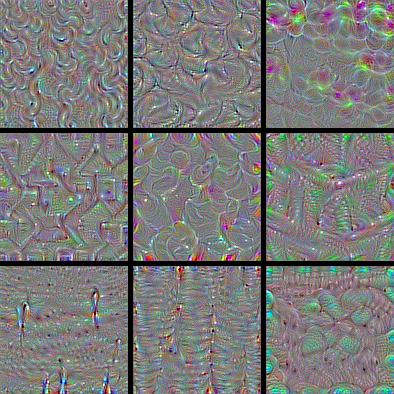

In [1]:
from imageio import imwrite
import numpy as np
import tensorflow as tf
from IPython.display import Image

image_width, image_height = 128, 128
vgg_model = tf.keras.applications.vgg16.VGG16(include_top=False)

input_image = vgg_model.input
vgg_layer_dict = dict([(vgg_layer.name, vgg_layer) for vgg_layer in vgg_model.layers[1:]])
vgg_layer_output = vgg_layer_dict['block5_conv1'].output


filters = []
for filter_idx in range(20):
    loss = tf.keras.backend.mean(vgg_layer_output[:, :, :, filter_idx])
    gradients = tf.keras.backend.gradients(loss, input_image)[0]
    gradient_mean_square = tf.keras.backend.mean(tf.keras.backend.square(gradients))
    gradients /= (tf.keras.backend.sqrt(gradient_mean_square) + 1e-5)
    evaluator = tf.keras.backend.function([input_image], [loss, gradients])

    gradient_ascent_step = 1.
    input_image_data = np.random.random((1, image_width, image_height, 3))
    input_image_data = (input_image_data - 0.5) * 20 + 128

    for i in range(20):
        loss_value, gradient_values = evaluator([input_image_data])
        input_image_data += gradient_values * gradient_ascent_step
        # print('Loss :', loss_value)
        if loss_value <= 0.:
            break

    if loss_value > 0:
        filter = input_image_data[0]
        filter -= filter.mean()
        filter /= (filter.std() + 1e-5)
        filter *= 0.1
        filter += 0.5
        filter = np.clip(filter, 0, 1)
        filter *= 255
        filter = np.clip(filter, 0, 255).astype('uint8')
        filters.append((filter, loss_value))


# For visualisation, not in book

n = 3

filters.sort(key=lambda x: x[1], reverse=True)
filters = filters[:n * n]

margin = 5
width = n * image_width + (n - 1) * margin
height = n * image_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        img, loss = filters[i * n + j]
        stitched_filters[(image_width + margin) * i: (image_width + margin) * i + image_width,
                         (image_height + margin) * j: (image_height + margin) * j + image_height, :] = img

imwrite('./data/stitched_filters_%dx%d.png' % (n, n), stitched_filters)
Image(filename='./data/stitched_filters_%dx%d.png' % (n, n), width=300)

## 3. deep dream

Instructions for updating:
Use tf.gfile.GFile.


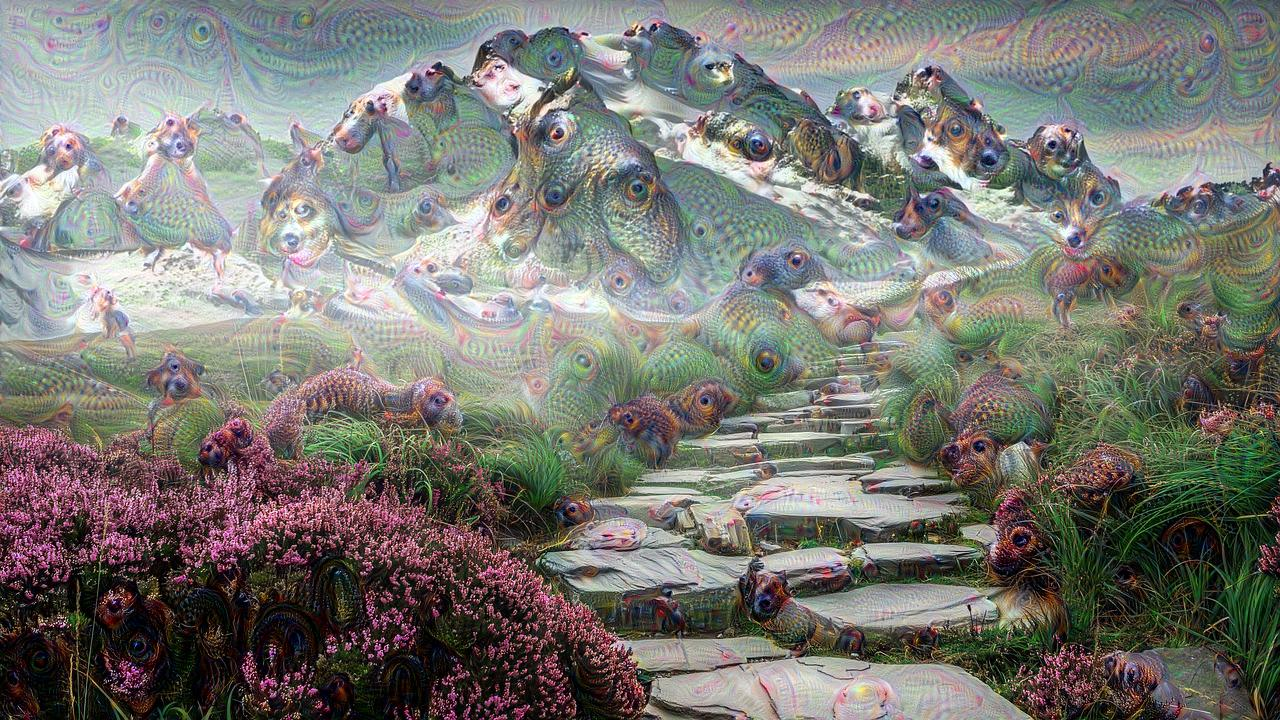

In [1]:
import os
import numpy as np
import PIL.Image
import urllib.request
from tensorflow.python.platform import gfile
import zipfile
from IPython.display import Image


import tensorflow as tf

work_dir = 'data'

model_url = 'https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip'

file_name = model_url.split('/')[-1]

file_path = os.path.join(work_dir, file_name)

if not os.path.exists(file_path):
    file_path, _ = urllib.request.urlretrieve(model_url, file_path)

zip_handle = zipfile.ZipFile(file_path, 'r')
zip_handle.extractall(work_dir)
zip_handle.close()

graph = tf.Graph()
session = tf.InteractiveSession(graph=graph)
model_path = os.path.join(work_dir, 'tensorflow_inception_graph.pb')
with gfile.FastGFile(model_path, 'rb') as f:
    graph_defnition = tf.GraphDef()
    graph_defnition.ParseFromString(f.read())

input_placeholder = tf.placeholder(np.float32, name='input')
imagenet_mean_value = 117.0
preprocessed_input = tf.expand_dims(input_placeholder-imagenet_mean_value, 0)
tf.import_graph_def(graph_defnition, {'input': preprocessed_input})


def resize_image(image, size):
    resize_placeholder = tf.placeholder(tf.float32)
    resize_placeholder_expanded = tf.expand_dims(resize_placeholder, 0)
    resized_image = tf.image.resize_bilinear(resize_placeholder_expanded, size)[0, :, :, :]
    return session.run(resized_image, feed_dict={resize_placeholder: image})


image_name = './src/Chapter03/mountain.jpg'
image = PIL.Image.open(image_name)
image = np.float32(image)
objective_fn = tf.square(graph.get_tensor_by_name("import/mixed4c:0"))

no_octave = 4
scale = 1.4
window_size = 51

score = tf.reduce_mean(objective_fn)
gradients = tf.gradients(score, input_placeholder)[0]

octave_images = []
for i in range(no_octave - 1):
    image_height_width = image.shape[:2]
    scaled_image = resize_image(image, np.int32(np.float32(image_height_width) / scale))
    image_difference = image - resize_image(scaled_image, image_height_width)
    image = scaled_image
    octave_images.append(image_difference)

for octave_idx in range(no_octave):
    if octave_idx > 0:
        image_difference = octave_images[-octave_idx]
        image = resize_image(image, image_difference.shape[:2]) + image_difference

    for i in range(10):
        image_heigth, image_width = image.shape[:2]
        sx, sy = np.random.randint(window_size, size=2)
        shifted_image = np.roll(np.roll(image, sx, 1), sy, 0)
        gradient_values = np.zeros_like(image)

        for y in range(0, max(image_heigth - window_size // 2, window_size), window_size):
            for x in range(0, max(image_width - window_size // 2, window_size), window_size):
                sub = shifted_image[y:y + window_size, x:x + window_size]
                gradient_windows = session.run(gradients, {input_placeholder: sub})
                gradient_values[y:y + window_size, x:x + window_size] = gradient_windows

        gradient_windows = np.roll(np.roll(gradient_values, -sx, 1), -sy, 0)
        image += gradient_windows * (1.5 / (np.abs(gradient_windows).mean() + 1e-7))

image /= 255.0
image = np.uint8(np.clip(image, 0, 1) * 255)
PIL.Image.fromarray(image).save('./data/dream_mountain.jpg', 'jpeg')
Image(filename='./data/dream_mountain.jpg', width=350)

## 4. auto encoder

In [1]:
import tensorflow as tf


def fully_connected_layer(input_layer, units):
    return tf.layers.dense(
        input_layer,
        units=units,
        activation=tf.nn.relu
    )


def convolution_layer(input_layer, filter_size):
    return  tf.layers.conv2d(
        input_layer,
        filters=filter_size,
        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
        kernel_size=3,
        strides=2
    )


def deconvolution_layer(input_layer, filter_size, activation=tf.nn.relu):
    return tf.layers.conv2d_transpose(
        input_layer,
        filters=filter_size,
        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
        kernel_size=3,
        activation=activation,
        strides=2
    )


input_layer = tf.placeholder(tf.float32, [None, 128, 128, 3])
convolution_layer_1 = convolution_layer(input_layer, 1024)
convolution_layer_2 = convolution_layer(convolution_layer_1, 512)
convolution_layer_3 = convolution_layer(convolution_layer_2, 256)
convolution_layer_4 = convolution_layer(convolution_layer_3, 128)
convolution_layer_5 = convolution_layer(convolution_layer_4, 32)

convolution_layer_5_flattened = tf.layers.flatten(convolution_layer_5)
bottleneck_layer = fully_connected_layer(convolution_layer_5_flattened, 16)
c5_shape = convolution_layer_5.get_shape().as_list()
c5f_flat_shape = convolution_layer_5_flattened.get_shape().as_list()[1]
fully_connected = fully_connected_layer(bottleneck_layer, c5f_flat_shape)
fully_connected = tf.reshape(fully_connected,
                             [-1, c5_shape[1], c5_shape[2], c5_shape[3]])

deconvolution_layer_1 = deconvolution_layer(fully_connected, 128)
deconvolution_layer_2 = deconvolution_layer(deconvolution_layer_1, 256)
deconvolution_layer_3 = deconvolution_layer(deconvolution_layer_2, 512)
deconvolution_layer_4 = deconvolution_layer(deconvolution_layer_3, 1024)
deconvolution_layer_5 = deconvolution_layer(deconvolution_layer_4, 3,
                                            activation=tf.nn.tanh)


## 5. denoising using auto encoder

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


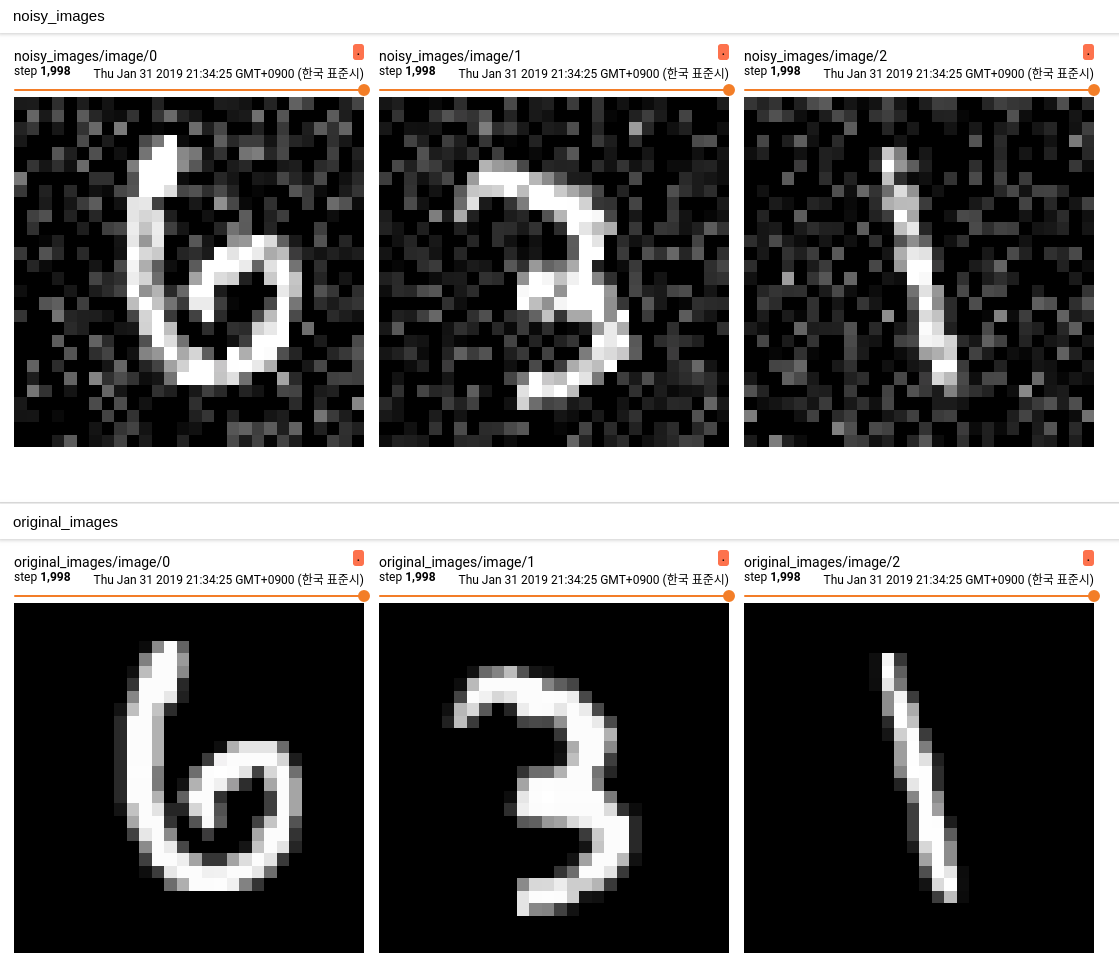

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
from IPython.display import Image


mnist_data = input_data.read_data_sets('MNIST_data', one_hot=True)

input_size = 784
no_classes = 10
batch_size = 100
total_batches = 2000

x_input = tf.placeholder(tf.float32, shape=[None, input_size])
y_input = tf.placeholder(tf.float32, shape=[None, input_size])


def add_variable_summary(tf_variable, summary_name):
    with tf.name_scope(summary_name + '_summary'):
        mean = tf.reduce_mean(tf_variable)
        tf.summary.scalar('Mean', mean)
        with tf.name_scope('standard_deviation'):
            standard_deviation = tf.sqrt(tf.reduce_mean(
                    tf.square(tf_variable - mean)))
        tf.summary.scalar('StandardDeviation', standard_deviation)
        tf.summary.scalar('Maximum', tf.reduce_max(tf_variable))
        tf.summary.scalar('Minimum', tf.reduce_min(tf_variable))
        tf.summary.histogram('Histogram', tf_variable)


def dense_layer(input_layer, units, activation=tf.nn.tanh):
    layer = tf.layers.dense(
        inputs=input_layer,
        units=units,
        activation=activation
    )
    add_variable_summary(layer, 'dense')
    return layer


layer_1 = dense_layer(x_input, 500)
layer_2 = dense_layer(layer_1, 250)
layer_3 = dense_layer(layer_2, 50)
layer_4 = dense_layer(layer_3, 250)
layer_5 = dense_layer(layer_4, 500)
layer_6 = dense_layer(layer_5, 784)

with tf.name_scope('loss'):
    softmax_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=y_input, logits=layer_6)
    loss_operation = tf.reduce_mean(softmax_cross_entropy, name='loss')
    tf.summary.scalar('loss', loss_operation)

with tf.name_scope('optimiser'):
    optimiser = tf.train.AdamOptimizer().minimize(loss_operation)

x_input_reshaped = tf.reshape(x_input, [-1, 28, 28, 1])
tf.summary.image("noisy_images", x_input_reshaped)

y_input_reshaped = tf.reshape(y_input, [-1, 28, 28, 1])
tf.summary.image("original_images", y_input_reshaped)

layer_6_reshaped = tf.reshape(layer_6, [-1, 28, 28, 1])
tf.summary.image("reconstructed_images", layer_6_reshaped)

session = tf.Session()
session.run(tf.global_variables_initializer())

merged_summary_operation = tf.summary.merge_all()
train_summary_writer = tf.summary.FileWriter('/tmp/train', session.graph)

for batch_no in range(total_batches):
    mnist_batch = mnist_data.train.next_batch(batch_size)
    train_images, _ = mnist_batch[0], mnist_batch[1]
    train_images_noise = train_images + 0.2 * np.random.normal(size=train_images.shape)
    train_images_noise = np.clip(train_images_noise, 0., 1.)
    _, merged_summary = session.run([optimiser, merged_summary_operation],
                                    feed_dict={
        x_input: train_images_noise,
        y_input: train_images,
    })
    train_summary_writer.add_summary(merged_summary, batch_no)

#!tensorboard --logdir=/tmp/train
Image(filename='./data/denoising.png', width=350)